# Notebook for interactive testing for CLIP

In [1]:
import gc
import os
from itertools import islice
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,max_split_size_mb:64"
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from transformers import pipeline, CLIPModel, CLIPProcessor
from tqdm import tqdm
# plot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Configuration
LOADER_PATCH_SIZE = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Cuda Availability:{torch.cuda.is_available()} Training on {device}")

C:\Users\Yukun\anaconda3\envs\sc4001\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Cuda Availability:True Training on cuda


In [11]:

class Cfg:
    model_id: str = "openai/clip-vit-base-patch32"
    batch_size: int = 32
    epochs: int = 40
    seed:   int = 42

    # -------- Optim & Loss ----------
    lr_head: float = 1e-3      
    wd_head: float = 1e-4
    lr_lora: float = 1e-3      
    wd_lora: float = 1e-2
    wd_backbone:float = 1e-4
    lr_backbone: float = 1e-3
    lambda_text: float = 0.3
    
    early_stopping: bool = True
    early_stop_patience = 3
    early_stop_minimum_improvement:float = 0.05
    

    # -------- LoRA ----------
    lora_enable: bool = False
    lora_rank: int = 8
    lora_alpha: int = 16
    lora_dropout: float = 0.0
    lora_target: tuple = ("q_proj","k_proj","v_proj","out_proj")

    amp: bool = True

cfg = Cfg()

PREPROCESS_DATA_ROOT = "../data/preprocessed"
torch.manual_seed(cfg.seed)
model_id = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_id).to(device).eval()
processor  = CLIPProcessor.from_pretrained(model_id)

In [12]:
# ---------- 2. Load Dataset ----------
def collate_pil(batch):
    # batch: List[ (PIL.Image.Image, int) ]
    images, labels = zip(*batch)           # images: tuple of PIL, labels: tuple of int
    return list(images), torch.tensor(labels)

def preprocess_dataset(split="train",data_root='../data',outputdir="../data/preprocessed",batchsize=cfg.batch_size,fp16=False):
    os.makedirs(outputdir,exist_ok=True)
    dataset = datasets.Flowers102(root=data_root, split=split, download=True)
    classes = dataset.classes
    loader = DataLoader(dataset, batch_size=batchsize, shuffle= True if split=="train" else False, num_workers=0,collate_fn=collate_pil)
    
    # Allocate RAM
    N = len(dataset)
    C, H, W = 3, 224, 224
    pixels = torch.empty((N,C,H,W), dtype=torch.float32 if not fp16 else torch.float16)
    labels = torch.empty(N, dtype=torch.long)
    
    print(f"Preprocessing {split} data...")
    
    index = 0
    with torch.no_grad():
        for images, y in tqdm(loader,desc=f"Preprocessing {split}"):
            pix = processor(images=images,return_tensors="pt")['pixel_values']
            if fp16:
                pix = pix.half()
            b = pix.size(0) # patch size
            pixels[index:index+b] = pix
            labels[index:index+b] = y
            index += b
    
    
    out_path = os.path.join(outputdir, f"{split}.pt")
    torch.save({"pixel_values": pixels, "labels": labels, "fp16": fp16,"classes":classes}, out_path)
    print(f"Saved → {out_path} (pixels: {pixels.shape}, dtype={pixels.dtype})")
    
    print("Performing Garbage Cleaning...")
    del pixels, labels
    torch.cuda.empty_cache()
    gc.collect()
    
    # for notebook
    %reset_selective -f pixels
    %reset_selective -f labels

class CacheDataset:
    def __init__(self, split="train", root="../data/preprocessed"):
        path = os.path.join(root, f"{split}.pt")
        obj = torch.load(path, map_location="cpu")
        self.pixel_values = obj["pixel_values"]
        self.labels = obj["labels"]
        self.fp16 = bool(obj.get("fp16", False))
        self.classes = obj['classes']
        
    def __len__(self):
        return self.labels.numel()
    
    def __getitem__(self, idx):
        return self.pixel_values[idx], self.labels[idx]
    
    
# Preprocess and save dataset                
if not os.path.exists(os.path.join(PREPROCESS_DATA_ROOT, "train.pt")):    
    preprocess_dataset(split="train",data_root="../data",outputdir=PREPROCESS_DATA_ROOT,fp16=False)
if not os.path.exists(os.path.join(PREPROCESS_DATA_ROOT, "val.pt")):  
    preprocess_dataset(split="val",data_root="../data",outputdir=PREPROCESS_DATA_ROOT,fp16=False)
if not os.path.exists(os.path.join(PREPROCESS_DATA_ROOT, "test.pt")):  
    preprocess_dataset(split="test",data_root="../data",outputdir=PREPROCESS_DATA_ROOT,fp16=False)




#Load dataset
train_set = CacheDataset(split="train")
val_set = CacheDataset(split="val")
test_set = CacheDataset(split="test")

classname = val_set.classes
classname




['pink primrose',
 'hard-leaved pocket orchid',
 'canterbury bells',
 'sweet pea',
 'english marigold',
 'tiger lily',
 'moon orchid',
 'bird of paradise',
 'monkshood',
 'globe thistle',
 'snapdragon',
 "colt's foot",
 'king protea',
 'spear thistle',
 'yellow iris',
 'globe-flower',
 'purple coneflower',
 'peruvian lily',
 'balloon flower',
 'giant white arum lily',
 'fire lily',
 'pincushion flower',
 'fritillary',
 'red ginger',
 'grape hyacinth',
 'corn poppy',
 'prince of wales feathers',
 'stemless gentian',
 'artichoke',
 'sweet william',
 'carnation',
 'garden phlox',
 'love in the mist',
 'mexican aster',
 'alpine sea holly',
 'ruby-lipped cattleya',
 'cape flower',
 'great masterwort',
 'siam tulip',
 'lenten rose',
 'barbeton daisy',
 'daffodil',
 'sword lily',
 'poinsettia',
 'bolero deep blue',
 'wallflower',
 'marigold',
 'buttercup',
 'oxeye daisy',
 'common dandelion',
 'petunia',
 'wild pansy',
 'primula',
 'sunflower',
 'pelargonium',
 'bishop of llandaff',
 'gaura',

In [13]:
# ---------- 3. DataLoader ----------
# ---------- Process of images is put on epoch loops

train_loader = DataLoader(
    train_set, batch_size=cfg.batch_size, shuffle=True,
    num_workers=0, pin_memory=True
    #workers should be 4, but got problems in notebook
)
val_loader = DataLoader(
    val_set, batch_size=cfg.batch_size, shuffle=False,
    num_workers=0, pin_memory=True
)
test_loader = DataLoader(
    test_set, batch_size=cfg.batch_size, shuffle=False,
    num_workers=0, pin_memory=True
)

---
## Model Setting and Training

In [14]:
# Word Prompt Embedding
import torch
from tqdm import tqdm

promptTemplate = {
    "A photo of {}.",
    "A photo of flower {}.",
    "Botanic picture of {}",
    "A example picture of type {}"
}
# Use more templates to reduce sensitivity to other contexts

@torch.no_grad()
def build_text_embeddings(names):
    embs = []
    for name in tqdm(names, desc="TextEmbed"):
        prompts = [t.format(name.replace("_"," ")) for t in promptTemplate] # insert class names
        inputs = processor(text=prompts, return_tensors="pt", padding=True).to(device)
        te = clip_model.get_text_features(**inputs)     # [T, D]
        te = te / te.norm(dim=-1, keepdim=True)
        embs.append(te.mean(dim=0))                     # [D]
    text = torch.stack(embs, dim=0)                     # [C, D]
    return text / text.norm(dim=-1, keepdim=True)

text_embs = build_text_embeddings(classname)          # [102, D], 固定不训练



TextEmbed: 100%|██████████| 102/102 [00:00<00:00, 116.39it/s]


----
## Building CLIP model with LoRA and word embedding.

Have to implement a LoRA linear layer ourselves.

In [6]:
# LoRA Injection (Trains LoRA matries only)
import torch, torch.nn as nn
from transformers.models.clip.modeling_clip import CLIPVisionModel

# y = w0 + x*(BA)*alpha/rank
# Shape of A: din by rank / Shape of B: rank by dout
class LoRALinearLayer(nn.Module):
    def __init__(self, base: nn.Linear, r=8, alpha=16, dropout=0.0):

        super().__init__()
        self.base = base # linear layer frozen for training LoRA parameters
        self.r = r
        self.scaling = alpha / r
        dev = base.weight.device
        dt  = base.weight.dtype

        

        if r > 0:
            self.lora_A = nn.Linear(base.in_features, r, bias=False).to(dev, dtype=dt)
            self.lora_B = nn.Linear(r, base.out_features, bias=False).to(dev, dtype=dt)
            self.dropout = nn.Dropout(dropout)
            nn.init.kaiming_uniform_(self.lora_A.weight,a=5**0.5)
            nn.init.zeros_(self.lora_B.weight) # set B to 0, avoid any bias introduced.
        else:
            self.lora_A = None
            self.lora_B = None
            self.dropout = nn.Identity()

            #Frozen
        for p in self.base.parameters():
            p.requires_grad = False

    def forward(self, x):
        if self.r > 0:
            return self.base(x) + self.dropout(self.lora_B(self.lora_A(x))) * self.scaling
        else:
            return self.base(x)


# LoRA Injection with warped LoRA layer shown above.

def lora_injection(clip_model: nn.Module, target_names=("q_proj","k_proj","v_proj","out_proj")):
    """
    """
    assert isinstance(clip_model.vision_model, CLIPVisionModel.__mro__[0].__class__) or hasattr(clip_model, "vision_model")
    lora_params = []
    for name, module in clip_model.vision_model.named_modules():
        # injection to clip/transformer attention layer: q_proj/k_proj/v_proj/out_proj
        for t in target_names:
            if hasattr(module, t):
                lin = getattr(module, t)
                if isinstance(lin, nn.Linear):
                    lora_lin = LoRALinearLayer(lin, r=cfg.lora_rank, alpha=cfg.lora_alpha, dropout=cfg.lora_dropout)
                    setattr(module, t, lora_lin)
                    lora_params += list(lora_lin.lora_A.parameters()) + list(lora_lin.lora_B.parameters())
    # Freeze the parameters
    for p in clip_model.vision_model.parameters():
        p.requires_grad = False
    for p in lora_params:
        p.requires_grad = True
    return lora_params

def build_head_and_optim(clip_model: CLIPModel):
    feat_dim = clip_model.config.projection_dim  # ViT-B/32 = 512
    head = nn.Linear(feat_dim, 102).to(device)

    lora_params = lora_injection(clip_model, target_names=cfg.lora_target)
    clip_model.to(device)

    # 2 parameter groups: LoRA and linear head
    optim = torch.optim.AdamW(
        [
            {"params": head.parameters(),      "lr": cfg.lr_head, "weight_decay": cfg.wd_head},
            {"params": lora_params,            "lr": cfg.lr_lora, "weight_decay": cfg.wd_lora},
        ]
    )
    scaler = torch.amp.GradScaler(enabled=(device=="cuda" and cfg.amp))
    return head, optim, scaler

def build_head_and_optim_no_lora(clip_model, num_classes=102, mode="linear"):
    feat_dim = clip_model.config.projection_dim  # e.g., ViT-B/32 = 512
    head = nn.Linear(feat_dim, num_classes).to(device)

    if mode == "linear":

        for p in clip_model.parameters():
            p.requires_grad = False
        param_groups = [
            {"params": head.parameters(), "lr": cfg.lr_head, "weight_decay": cfg.wd_head},
        ]
    elif mode == "full":

        for p in clip_model.parameters():
            p.requires_grad = False
        for p in clip_model.vision_model.parameters():
            p.requires_grad = True
        param_groups = [
            {"params": head.parameters(),                       "lr": cfg.lr_head,      "weight_decay": cfg.wd_head},
            {"params": clip_model.vision_model.parameters(),    "lr": cfg.lr_backbone,  "weight_decay": cfg.wd_backbone},
        ]
    else:
        raise ValueError("mode must be 'linear' or 'full'")

    optimizer = torch.optim.AdamW(param_groups)
    scaler = torch.amp.GradScaler(enabled=(device=="cuda" and cfg.amp))
    clip_model.to(device)
    return head, optimizer, scaler


In [16]:
if cfg.lora_enable:
    head, optimizer, scaler = build_head_and_optim(clip_model)
else:
    head, optimizer, scaler = build_head_and_optim_no_lora(clip_model,mode='linear')
ce = torch.nn.CrossEntropyLoss()

def get_image_feats(images):
    # images are actual tensor now
    # assume it's preprocessed
    if isinstance(images, torch.Tensor):
        pixel_values = images.to(device, dtype=torch.float16 if (device=="cuda" and cfg.amp) else torch.float32)
    else:
        inputs = processor(images=images, return_tensors="pt").to(device)
        pixel_values = inputs["pixel_values"]
        
    feats = clip_model.get_image_features(pixel_values=pixel_values)           # [B, D]
    feats = feats / feats.norm(dim=-1, keepdim=True)
    return feats

def supervised_logits(feats):
    return head(feats)                                        # [B, 102]

def text_logits(feats):
    # perform cosine similarity with text embedding.
    return (feats @ text_embs.T) * clip_model.logit_scale.exp()

z
----
## Main Training Epoch

In [17]:
from collections import defaultdict
class EarlyStopper:
    def __init__(self):
        self.counter = 0
        self.last_loss = 0
        self.patience = cfg.early_stop_patience
        self.enable = cfg.early_stopping
        self.delta = cfg.early_stop_minimum_improvement
    def report(self,loss):
        if self.last_loss - loss < self.delta:
            self.counter += 1
        else:
            self.counter = 0
        self.last_loss = loss
    
    def stop_flag(self):
        return self.enable and (self.counter >= self.patience)
        
def run_epoch(loader: DataLoader, train: bool=True):
    if train:
        head.train()
        clip_model.train()
    else:
        head.eval()
        clip_model.eval()

    total, correct_cls, correct_txt = 0, 0, 0
    loss_sum = 0.0
    
    correct_per_label = defaultdict(int)
    total_per_label = defaultdict(int)
    
    for images, labels in tqdm(loader, desc="Train" if train else "Eval"):
        labels = labels.to(device)
        with torch.amp.autocast(device_type=device,enabled=(device=="cuda" and cfg.amp)):
            feats = get_image_feats(images)                   # [B, D]

            logits_cls = supervised_logits(feats) # logits of classification score from linear layer head
            loss_cls = ce(logits_cls, labels)

            logits_txt = text_logits(feats) # logits of text embedding trained in transformer
            loss_txt = ce(logits_txt, labels)
            # Alignment between text and img.

            loss = loss_cls + cfg.lambda_text * loss_txt # weighted
            

        if train:
            # backward propagation
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()


        #Stats
        pred_cls = logits_cls.argmax(dim=-1)
        pred_txt = logits_txt.argmax(dim=-1)
        
        loss_sum += loss.item() * labels.size(0)
        total += labels.size(0)
        correct_cls += (logits_cls.argmax(dim=-1) == labels).sum().item()
        correct_txt += (logits_txt.argmax(dim=-1) == labels).sum().item()
        # Label_wise
        for label, pred in zip(labels, pred_cls):
            label = label.item()
            total_per_label[label] += 1
            if pred.item() == label:
                correct_per_label[label] += 1
    
    
    
    label_acc = {lbl: correct_per_label[lbl] / total_per_label[lbl]
                 for lbl in total_per_label.keys()}
    
        
    loss_avg = loss_sum / total
    
    return {
    "loss": loss_avg,
    "acc_cls": correct_cls/total,
    "acc_txt": correct_txt/total,
    "label_acc": label_acc
}

def test_epoch(loader: DataLoader, train: bool=True):
    if train:
        head.train()
        clip_model.train()
    else:
        head.eval()
        clip_model.eval()

    total, correct_cls, correct_txt = 0, 0, 0
    loss_sum = 0.0
    correct_per_label = defaultdict(int)
    total_per_label = defaultdict(int)


    all_labels = []
    all_preds = []

    for images, labels in tqdm(loader, desc="Train" if train else "Eval"):
        labels = labels.to(device)
        with torch.amp.autocast(device_type=device, enabled=(device=="cuda" and cfg.amp)):
            feats = get_image_feats(images)
            logits_cls = supervised_logits(feats)
            loss_cls = ce(logits_cls, labels)
            logits_txt = text_logits(feats)
            loss_txt = ce(logits_txt, labels)
            loss = loss_cls + cfg.lambda_text * loss_txt

        if train:
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        pred_cls = logits_cls.argmax(dim=-1)
        pred_txt = logits_txt.argmax(dim=-1)

        loss_sum += loss.item() * labels.size(0)
        total += labels.size(0)
        correct_cls += (pred_cls == labels).sum().item()
        correct_txt += (pred_txt == labels).sum().item()


        for label, pred in zip(labels, pred_cls):
            label = label.item()
            total_per_label[label] += 1
            if pred.item() == label:
                correct_per_label[label] += 1


        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(pred_cls.cpu().numpy())

    # === Label-wise accuracy ===
    label_acc = {
        lbl: correct_per_label[lbl] / total_per_label[lbl]
        for lbl in total_per_label.keys()
    }

    # === Confusion matrix ===
    cm = confusion_matrix(all_labels, all_preds)
    fig, ax = plt.subplots(figsize=(20, 20))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    plt.title("Confusion Matrix")
    plt.show()

    loss_avg = loss_sum / total

    return {
        "loss": loss_avg,
        "acc_cls": correct_cls / total,
        "acc_txt": correct_txt / total,
        "label_acc": label_acc,
        "confusion_matrix": cm,
    }

Eval: 100%|██████████| 32/32 [00:01<00:00, 19.50it/s]


[1/100] Train: loss=5.1032 acc_cls=0.0559 acc_txt=0.6392 | Val:   loss=5.0415 acc_cls=0.2147 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.63it/s]


[2/100] Train: loss=5.0240 acc_cls=0.3853 acc_txt=0.6392 | Val:   loss=4.9747 acc_cls=0.5441 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.56it/s]


[3/100] Train: loss=4.9517 acc_cls=0.6549 acc_txt=0.6392 | Val:   loss=4.9090 acc_cls=0.6725 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.71it/s]


[4/100] Train: loss=4.8797 acc_cls=0.7833 acc_txt=0.6392 | Val:   loss=4.8439 acc_cls=0.7618 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.56it/s]


[5/100] Train: loss=4.8090 acc_cls=0.8814 acc_txt=0.6392 | Val:   loss=4.7796 acc_cls=0.8304 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.69it/s]


[6/100] Train: loss=4.7388 acc_cls=0.9147 acc_txt=0.6392 | Val:   loss=4.7159 acc_cls=0.8441 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.64it/s]


[7/100] Train: loss=4.6694 acc_cls=0.9294 acc_txt=0.6392 | Val:   loss=4.6534 acc_cls=0.8520 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.54it/s]


[8/100] Train: loss=4.6006 acc_cls=0.9373 acc_txt=0.6392 | Val:   loss=4.5908 acc_cls=0.8529 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.74it/s]


[9/100] Train: loss=4.5322 acc_cls=0.9461 acc_txt=0.6392 | Val:   loss=4.5295 acc_cls=0.8676 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.66it/s]


[10/100] Train: loss=4.4647 acc_cls=0.9490 acc_txt=0.6392 | Val:   loss=4.4681 acc_cls=0.8667 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.61it/s]


[11/100] Train: loss=4.3981 acc_cls=0.9559 acc_txt=0.6392 | Val:   loss=4.4083 acc_cls=0.8676 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.68it/s]


[12/100] Train: loss=4.3321 acc_cls=0.9510 acc_txt=0.6392 | Val:   loss=4.3488 acc_cls=0.8676 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.57it/s]


[13/100] Train: loss=4.2662 acc_cls=0.9578 acc_txt=0.6392 | Val:   loss=4.2899 acc_cls=0.8716 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.74it/s]


[14/100] Train: loss=4.2024 acc_cls=0.9578 acc_txt=0.6392 | Val:   loss=4.2319 acc_cls=0.8784 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.73it/s]


[15/100] Train: loss=4.1387 acc_cls=0.9569 acc_txt=0.6392 | Val:   loss=4.1744 acc_cls=0.8716 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.61it/s]


[16/100] Train: loss=4.0747 acc_cls=0.9598 acc_txt=0.6392 | Val:   loss=4.1174 acc_cls=0.8716 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.73it/s]


[17/100] Train: loss=4.0125 acc_cls=0.9608 acc_txt=0.6392 | Val:   loss=4.0613 acc_cls=0.8725 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.70it/s]


[18/100] Train: loss=3.9508 acc_cls=0.9569 acc_txt=0.6392 | Val:   loss=4.0056 acc_cls=0.8725 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.59it/s]


[19/100] Train: loss=3.8895 acc_cls=0.9608 acc_txt=0.6392 | Val:   loss=3.9509 acc_cls=0.8755 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.66it/s]


[20/100] Train: loss=3.8291 acc_cls=0.9608 acc_txt=0.6392 | Val:   loss=3.8969 acc_cls=0.8735 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.49it/s]


[21/100] Train: loss=3.7697 acc_cls=0.9588 acc_txt=0.6392 | Val:   loss=3.8436 acc_cls=0.8794 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.75it/s]


[22/100] Train: loss=3.7110 acc_cls=0.9588 acc_txt=0.6392 | Val:   loss=3.7911 acc_cls=0.8804 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.83it/s]


[23/100] Train: loss=3.6524 acc_cls=0.9598 acc_txt=0.6392 | Val:   loss=3.7394 acc_cls=0.8794 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.55it/s]


[24/100] Train: loss=3.5960 acc_cls=0.9608 acc_txt=0.6392 | Val:   loss=3.6879 acc_cls=0.8833 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.77it/s]


[25/100] Train: loss=3.5388 acc_cls=0.9598 acc_txt=0.6392 | Val:   loss=3.6374 acc_cls=0.8833 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.68it/s]


[26/100] Train: loss=3.4828 acc_cls=0.9637 acc_txt=0.6392 | Val:   loss=3.5878 acc_cls=0.8804 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.68it/s]


[27/100] Train: loss=3.4287 acc_cls=0.9647 acc_txt=0.6392 | Val:   loss=3.5386 acc_cls=0.8833 acc_txt=0.6716


Eval: 100%|██████████| 32/32 [00:01<00:00, 19.78it/s]


[28/100] Train: loss=3.3748 acc_cls=0.9637 acc_txt=0.6392 | Val:   loss=3.4902 acc_cls=0.8863 acc_txt=0.6716
Early stop triggered...Exiting on epoch 28


Eval: 100%|██████████| 193/193 [00:09<00:00, 19.72it/s]


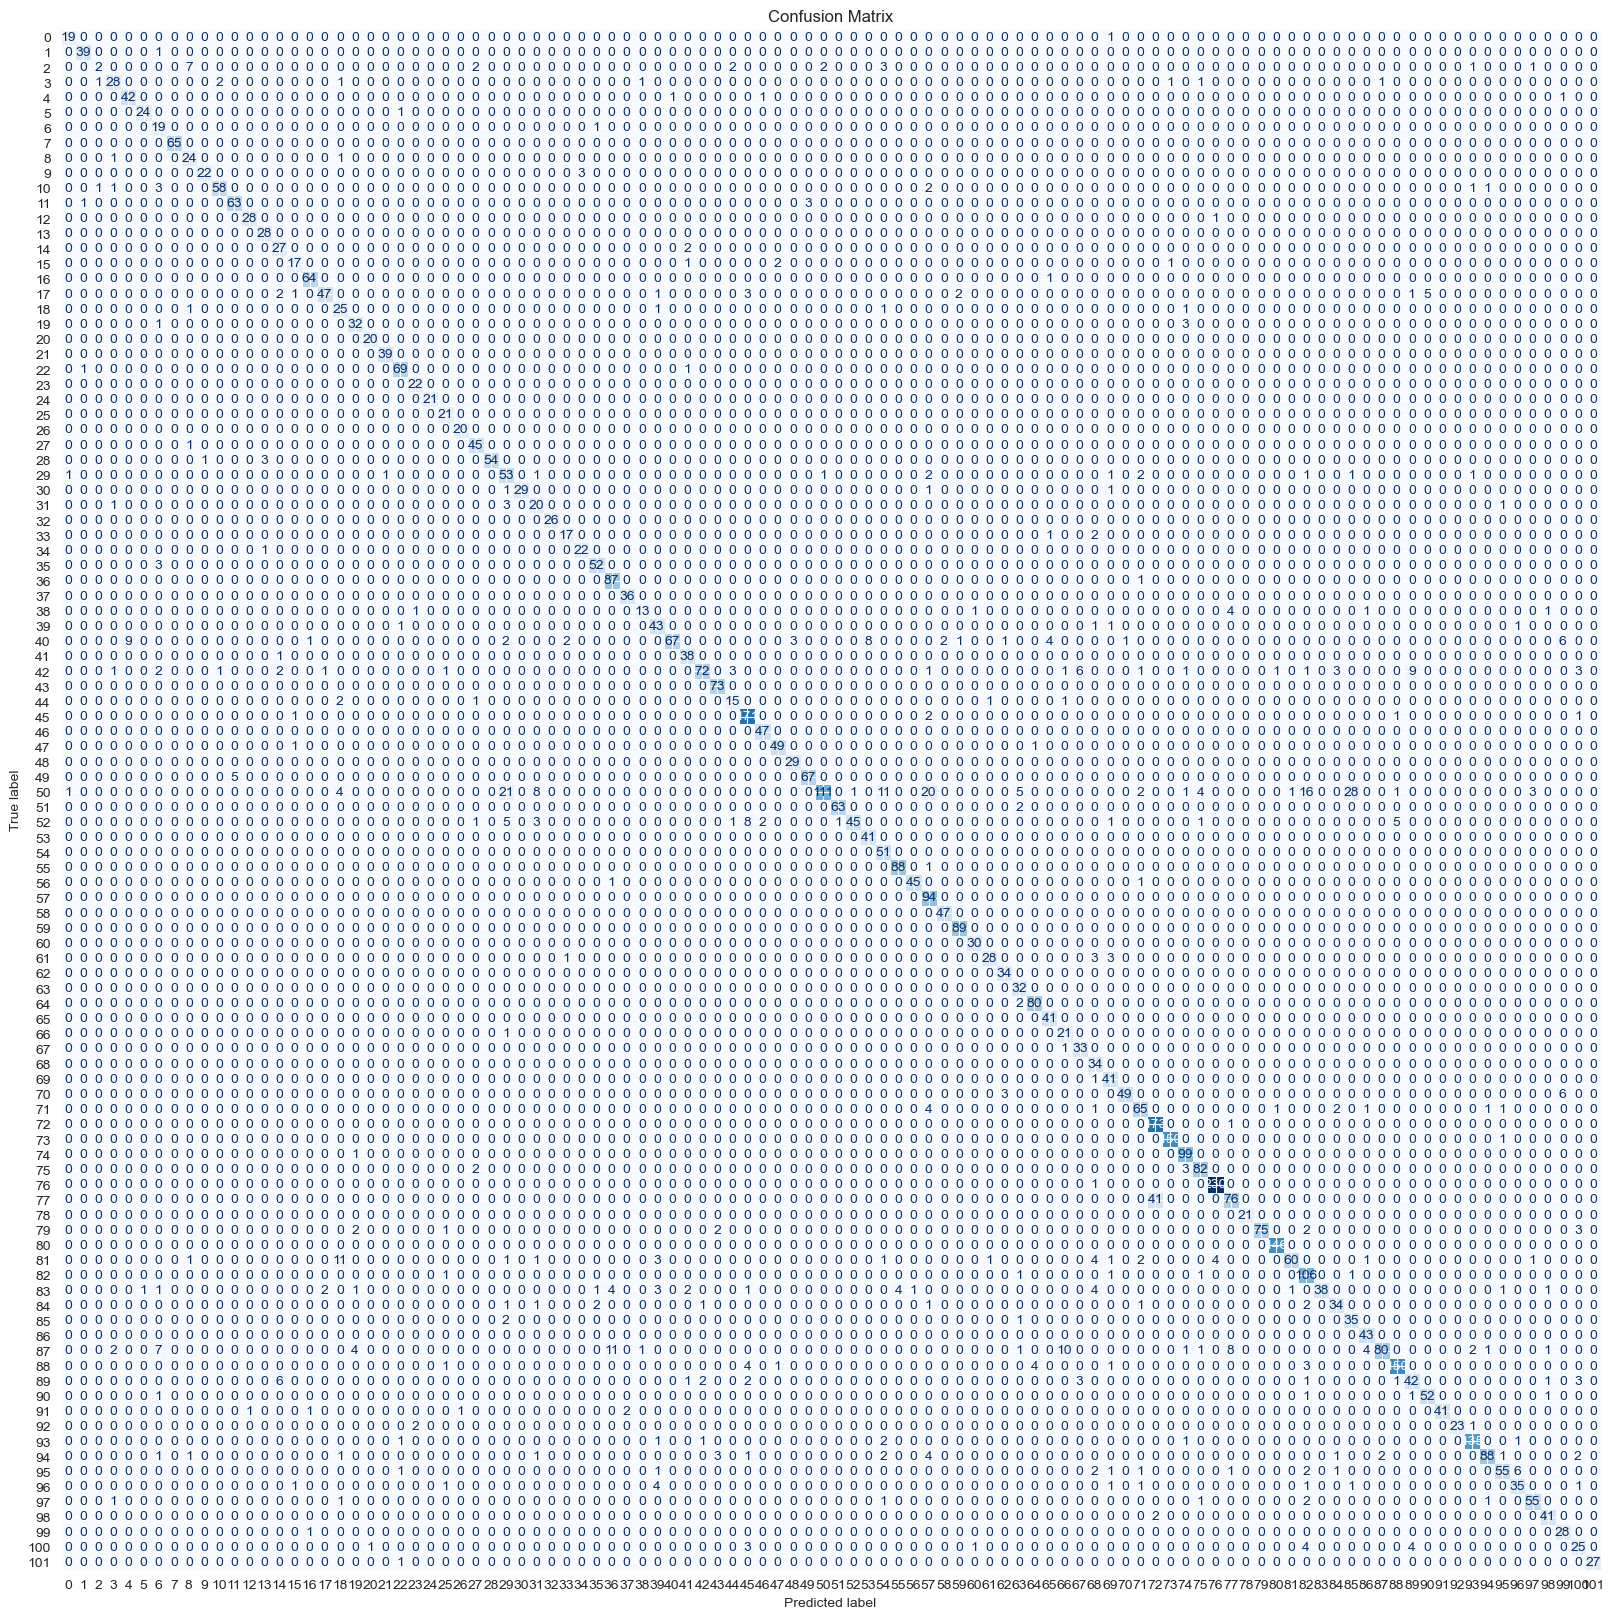

Test: loss=3.5247  acc_cls=0.8810  acc_txt=0.6451


In [18]:
best_val = -1.0
best_head = None
earlystop = EarlyStopper()
epoch_stat = []
eps = cfg.epochs+1 if cfg.lora_enable else 100
for ep in range(1,eps):
    training = run_epoch(train_loader, train=True)
    val = run_epoch(val_loader, train=False)
    print(f"[{ep}/{eps}] "
          f"Train: loss={training['loss']:.4f} acc_cls={training['acc_cls']:.4f} acc_txt={training['acc_txt']:.4f} | "
          f"Val:   loss={val['loss']:.4f} acc_cls={val['acc_cls']:.4f} acc_txt={val['acc_txt']:.4f}")

    if val["acc_cls"] > best_val:
        best_val = val["acc_cls"]
        best_head = { k: v.detach().cpu() for k, v in head.state_dict().items() } # Detach the parameters from autograd (keeps weights only)
    earlystop.report(val['loss'])
    epoch_stat.append([ep,training['loss'],val['loss'],training['acc_cls'],val['acc_cls']])
    if earlystop.stop_flag():
        print(f"Early stop triggered...Exiting on epoch {ep}")
        break


if best_head is not None:
    head.load_state_dict({k: v.to(device) for k, v in best_head.items()})
te = test_epoch(test_loader, train=False)
print(f"Test: loss={te['loss']:.4f}  acc_cls={te['acc_cls']:.4f}  acc_txt={te['acc_txt']:.4f}")

pd.DataFrame(epoch_stat).to_csv('../nolora-vanilla.csv')

Eval: 100%|██████████| 193/193 [00:11<00:00, 17.54it/s]


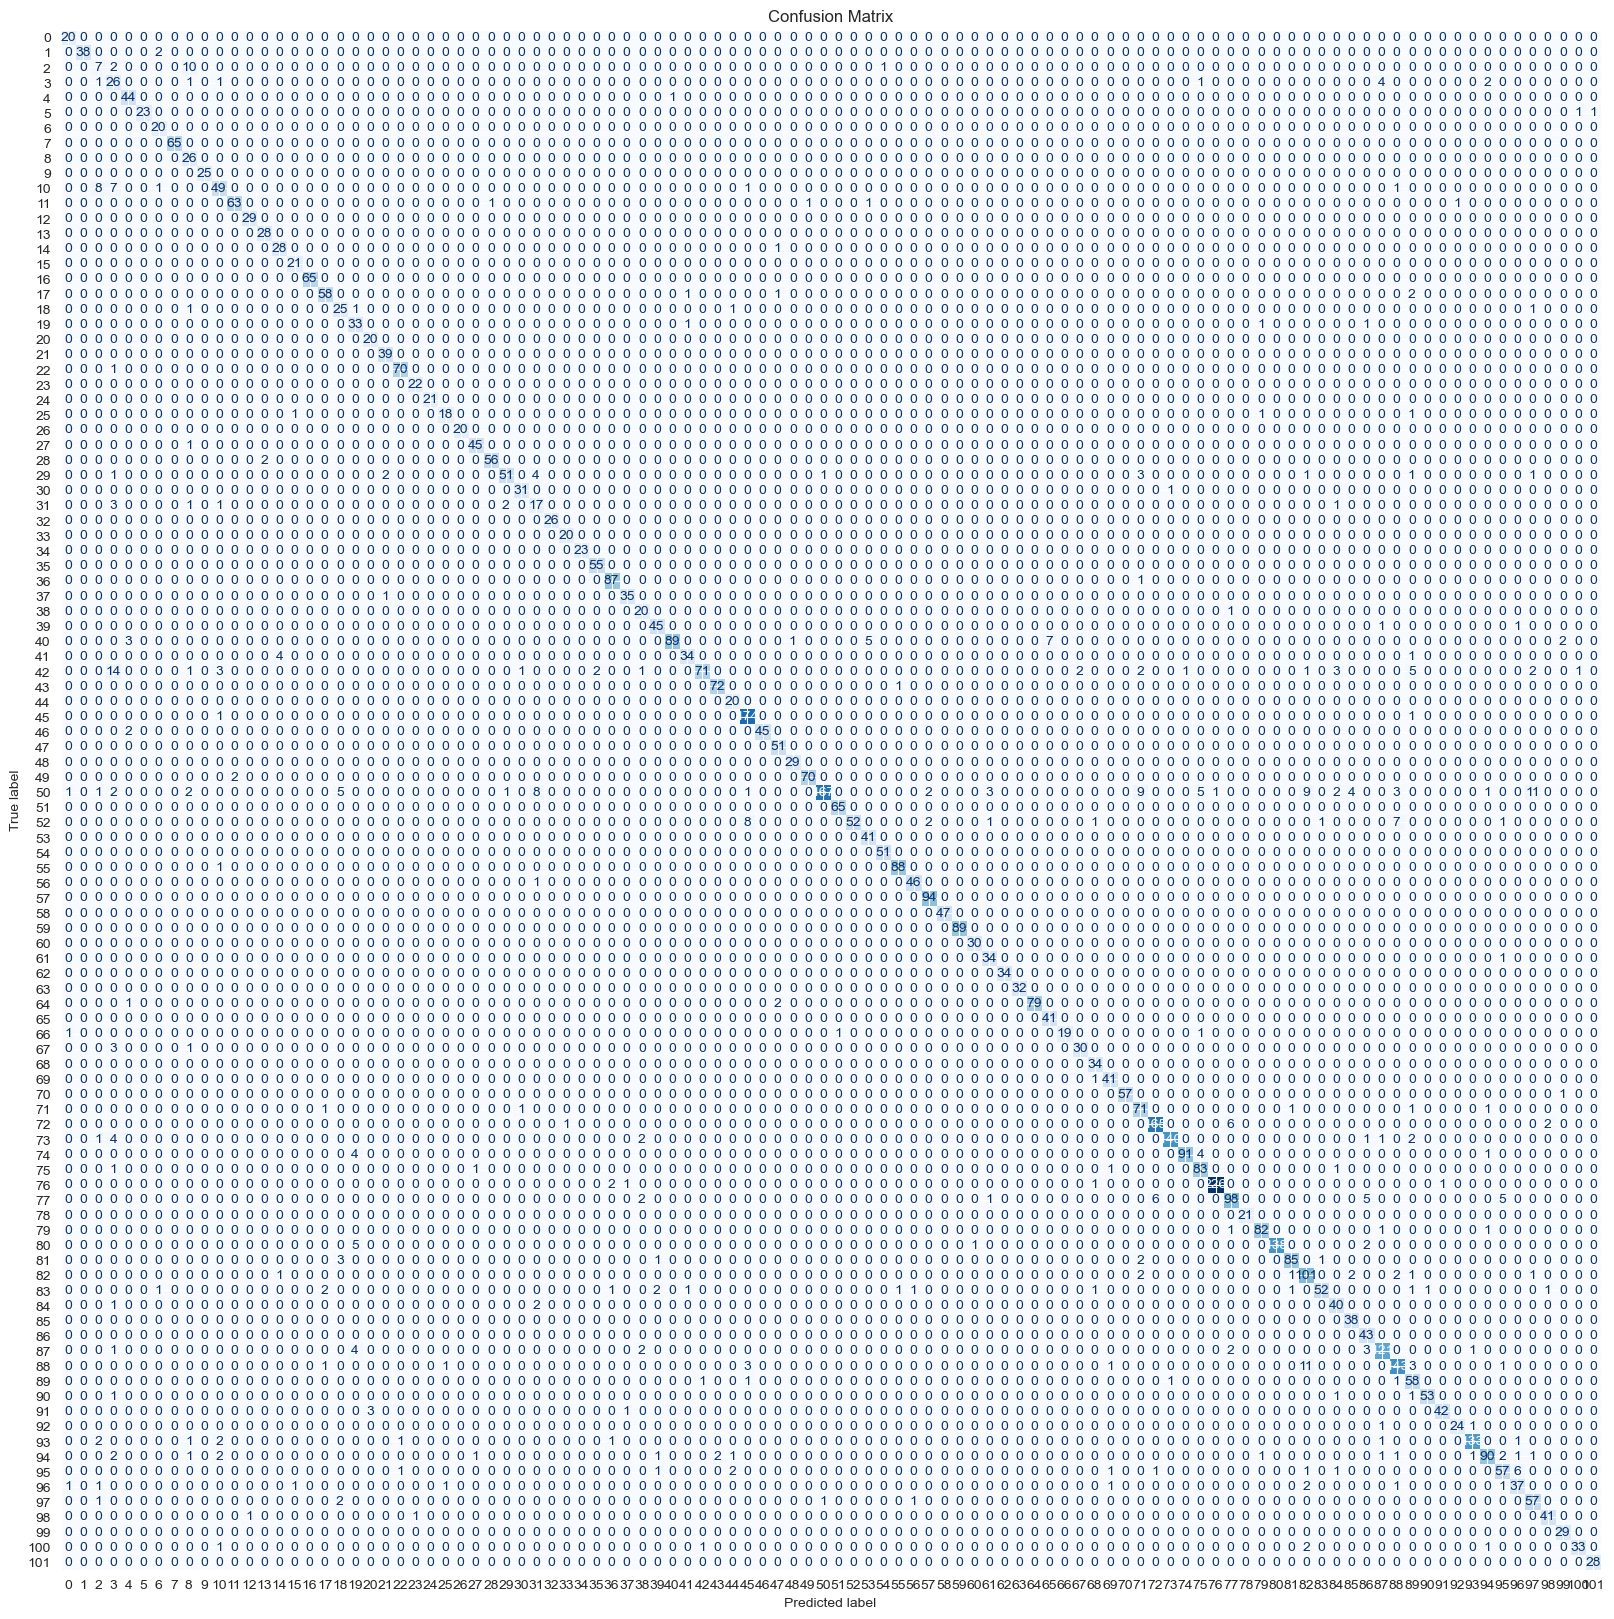

Test: loss=1.6504  acc_cls=0.9205  acc_txt=0.8522


In [13]:
te = test_epoch(test_loader, train=False)
print(f"Test: loss={te['loss']:.4f}  acc_cls={te['acc_cls']:.4f}  acc_txt={te['acc_txt']:.4f}")

pd.DataFrame(epoch_stat).to_csv('../vanilla.csv')

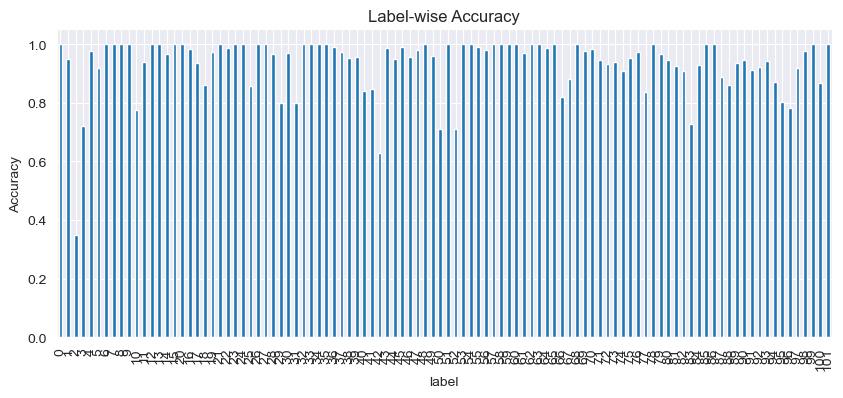

In [13]:
import pandas as pd

df = pd.DataFrame(list(te["label_acc"].items()), columns=["label", "accuracy"])
df.columns = ['label','Vanilla-CLIP']
df.to_csv('../clip_test.csv')
df.plot.bar(x="label", y="Vanilla-CLIP", figsize=(10,4), legend=False)
plt.title("Label-wise Accuracy")
plt.ylabel("Accuracy")
plt.show()

## Save trained model
### Save head layer and LoRA layers only

In [ ]:
# Save Trained weights, as only head layer is trained
def save_light_model(path,clip_model,head):
    # sort out LoRA layers
    lora_states = {k:v for k,v in clip_model.state_dict().items() if "lora_" in k}
    checkpoint = {
        "clip_name": "openai/clip-vit-base-patch32",
        "num_of_classes": head.out_features,
        "head_state_dict": head.state_dict(),
        "lora_states": lora_states,
    }
    torch.save(checkpoint,path)
    print(f"Light weight model (only contains head and LoRA) saved to {path}")


    # Return clip_lora, head
def load_light_simple(path, device=device, lora_targets=("q_proj","k_proj","v_proj","out_proj")):
    checkpoint = torch.load(path, map_location=device)
    clip_model = CLIPModel.from_pretrained(checkpoint["clip_name"]).to(device)

    # Injection again
    lora_injection(clip_model, target_names=lora_targets)
    # Load weights to injected layers
    missing, unexpected = clip_model.load_state_dict(checkpoint["lora_states"], strict=False) # set to false allow partial loading
    print(missing, unexpected)

    feat_dim = clip_model.config.projection_dim
    head = nn.Linear(feat_dim,checkpoint["num_of_classes"]).to(device)
    head.load_state_dict(checkpoint["head_state_dict"])

    print(f"[light] loaded ← {path}")
    return clip_model, head



from pathlib import Path



# Transformer Style Saving

def save_full_dir(output_dir, clip_model, head):
    output = Path(output_dir)
    output.mkdir(parents=True, exist_ok=True)
    clip_model.save_pretrained(output)
    torch.save({"num_classes": head.out_features,
                "state_dict": head.state_dict()}, output/"head.pt")
    print(f"[full-dir] saved → {output}")

def load_full_dir(output_dir, device=device, lora_targets=("q_proj","k_proj","v_proj","out_proj")):
    from transformers import CLIPModel
    output = Path(output_dir)

    clip_model = CLIPModel.from_pretrained(output).to(device)  # Load from folder
    # Most of the cases LoRA parameters are lost so manually inject again

    head_ckpt = torch.load(output/"head.pt", map_location=device)
    import torch.nn as nn
    head = nn.Linear(clip_model.config.projection_dim, head_ckpt["num_classes"]).to(device)
    head.load_state_dict(head_ckpt["state_dict"])
    print(f"[full-dir] loaded ← {output}")
    return clip_model, head







# Single File
def save_full_model(path,clip_model,head):
    checkpoint = {
        "clip_name": "openai/clip-vit-base-patch32",
        "num_of_classes": head.out_features,
        "clip_state_dict": clip_model.state_dict(),
        "head_state_dict": head.state_dict(),
    }
    torch.save(checkpoint,path)
    print(f"Full  model  saved to {path}")

def load_full_model(path,device=device, lora_targets=("q_proj","k_proj","v_proj","out_proj")):
    checkpoint = torch.load(path, map_location=device)

    print(checkpoint["clip_name"])
    clip_model = CLIPModel.from_pretrained(checkpoint["clip_name"]).to(device)

    # Injection again
    lora_injection(clip_model, target_names=lora_targets)
    # Load weights to injected layers
    clip_model.load_state_dict(checkpoint["clip_state_dict"], strict=True) # This time true cause loading full model

    head = nn.Linear(clip_model.config.projection_dim,checkpoint["num_of_classes"]).to(device)
    head.load_state_dict(checkpoint["head_state_dict"])

    print(f"Full  model  loaded from {path}")
    return clip_model, head


In [ ]:
# Actual Saving Code
os.makedirs("model",exist_ok=True)
save_light_model("model/clip_weights.pt", clip_model, head)

In [ ]:
# Try loading one
clip_model, head = load_light_simple("model/clip_weights.pt")

from itertools import islice
clip_model.eval()
head.eval()
processor = CLIPProcessor.from_pretrained(getattr(clip_model, "name_or_path", "openai/clip-vit-base-patch32"))

def collate_pil(batch):
    imgs, labels = zip(*batch)
    return list(imgs), torch.tensor(labels, dtype=torch.long)

val_set  = datasets.Flowers102(root="./data", split="val",  download=True)
test_set = datasets.Flowers102(root="./data", split="test", download=True)
val_loader  = DataLoader(val_set,  batch_size=64, shuffle=False, num_workers=0, collate_fn=collate_pil)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0, collate_fn=collate_pil)

@torch.no_grad()
def evaluate_first(loader):
    total, correct = 0, 0
    for images, labels in loader:
        labels = labels.to(device)
        inputs = processor(images=images, return_tensors="pt").to(device)
        feats = clip_model.get_image_features(**inputs)          # [B, D]
        feats = feats / feats.norm(dim=-1, keepdim=True)
        logits = head(feats)                                     # [B, C]
        pred = logits.argmax(dim=-1)
        correct += (pred == labels).sum().item()
        total   += labels.size(0)
    return correct / total


val_acc  = evaluate_first(val_loader)
test_acc = evaluate_first(test_loader)
print(f"Val Acc = {val_acc:.4f} | Test Acc = {test_acc:.4f}")

In [ ]:
# This block saves full model

# save_full_model("model/full_model.pt", clip_model, head)
# clip_model, head = load_full_model("model/full_model.pt")

----
## Fine-Tuning of CLIP: Visual Prompt Tuning

We insert a learnable prompt before encoder of transformer, along with the images.

In [20]:
# Config
VISUAL_PROMPT_SIZE = 16

class VPTDeepClip(nn.Module):
    def __init__(self, clip_model: CLIPModel, init_std: float = 0.02, freeze_backbone: bool = True, share_prompt:bool = True):
        super().__init__()
        self.clip = clip_model
        vm = self.clip.vision_model
        D = vm.config.hidden_size # Hidden size of embedding
        m = VISUAL_PROMPT_SIZE
        L = vm.config.num_hidden_layers # Layers of vm, as we are going to inject prompt to each layer
        self.prompt =   nn.Parameter(torch.randn(m, D) * init_std)
        self.prompt_pos = nn.Parameter(torch.zeros(1,m, D)) # Positional Encoding, each one is different thus need B different ones.
        
        if share_prompt:
            self.prompt     = nn.Parameter(torch.randn(m, D) * init_std)   # share same prompt for each layer
            self.prompt_pos = nn.Parameter(torch.zeros(1, m, D))           
        else:
            self.prompt     = nn.Parameter(torch.randn(L, m, D) * init_std)# Different prompts for each layer (to train)
            self.prompt_pos = nn.Parameter(torch.zeros(1, L, m, D))        # 1, L, m, D]
        
        
        if freeze_backbone:
            for p in self.clip.vision_model.parameters():
                p.requires_grad = False
            for p in self.clip.visual_projection.parameters():
                p.requires_grad = False
        
        
    @torch.no_grad()
    def embed_with_pos(self, pixel_values: torch.Tensor) -> torch.Tensor:
        # reuse
        return self.clip.vision_model.embeddings(pixel_values)
    
    def _encode_with_prompts(self, x: torch.Tensor) -> torch.Tensor:
    # CLS+ img patch = [B, 1+N, D]
    # we add prompt and prompt_pos into the vector before the actual image.
    
        vm = self.clip.vision_model
        B = x.size(0)
        
        h = vm.pre_layrnorm(x)                                             # [B, 1+N, D] Prelayer norm
        
        
        attn_mask = None
        causal_mask = None
        
        # inject
        for l, block in enumerate(vm.encoder.layers):
            cls     = h[:, :1, :]                                          # [B,1,D]
            rest    = h[:, 1:, :]                                          # [B,N,D]

            if self.prompt.dim() == 2:                                     # Share
                P = (self.prompt + self.prompt_pos)                        # [m,D] + [1,m,D] → [1,m,D]
            else:                                                          # By layer
                P = (self.prompt[l] + self.prompt_pos[:, l])               # [m,D] + [1,m,D] → [1,m,D]

            P = P.expand(B, -1, -1)                                        # [B,m,D]
            h_in = torch.cat([cls, P, rest], dim=1)                        # [B,1+m+N,D]

            # block feed-forward
            out = block(
            hidden_states=h_in,
            attention_mask=attn_mask,
            causal_attention_mask=causal_mask,
            output_attentions=False,
            )
            if isinstance(out, (tuple, list)):
                h = out[0]
            elif hasattr(out, "hidden_states"):
                h = out.hidden_states
            else:
                h = out

        h = vm.post_layernorm(h)                                           # [B,1+m+N,D]
        return h

    
    def get_image_features(self, pixel_values: torch.Tensor) -> torch.Tensor:
        # align with CLIPmodel.get_image_features to ensure code reusable
        pixel_values = pixel_values.to(next(self.parameters()).device, dtype=next(self.parameters()).dtype)
        
        x = self.embed_with_pos(pixel_values) # [B,1+N,D]
        
        last = self._encode_with_prompts(x)
        
        pooled = last[:,0,:] # get cls [B,D]
        
        feats = self.clip.visual_projection(pooled)       # [B, projection_dim]
        return feats
    
    def vpt_parameters(self):
        return [self.prompt, self.prompt_pos]
        
def lora_injection(clip_model: nn.Module, target_names=("q_proj","k_proj","v_proj","out_proj")):
    """
    """
    assert hasattr(clip_model, "vision_model"), "CLIP model missing vision_model"
    lora_params = []
    for name, module in clip_model.vision_model.named_modules():
        # injection to clip/transformer attention layer: q_proj/k_proj/v_proj/out_proj
        for t in target_names:
            if hasattr(module, t):
                lin = getattr(module, t)
                if isinstance(lin, nn.Linear):
                    lora_lin = LoRALinearLayer(lin, r=cfg.lora_rank, alpha=cfg.lora_alpha, dropout=cfg.lora_dropout)
                    setattr(module, t, lora_lin)
                    lora_params += list(lora_lin.lora_A.parameters()) + list(lora_lin.lora_B.parameters())
    # Freeze the parameters
    for p in clip_model.vision_model.parameters():
        p.requires_grad = False
    for p in lora_params:
        p.requires_grad = True
    return lora_params


def build_head_and_optim_vpt(clip_model: CLIPModel):
    feat_dim = clip_model.config.projection_dim  # ViT-B/32 = 512
    head = nn.Linear(feat_dim, 102).to(device)

    lora_params = lora_injection(clip_model, target_names=cfg.lora_target)
    clip_model.to(device)

    # 2 parameter groups: LoRA and linear head
    optim = torch.optim.AdamW(
        [
            {"params": head.parameters(),      "lr": cfg.lr_head, "weight_decay": cfg.wd_head},
            {"params": lora_params,            "lr": cfg.lr_lora, "weight_decay": cfg.wd_lora},
            {"params": vpt.vpt_parameters(), "lr": 5e-3, "weight_decay": 0.0},
        ]
    )
    scaler = torch.amp.GradScaler(enabled=(device=="cuda" and cfg.amp))
    return head, optim, scaler

In [21]:
# Re init

device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor  = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

vpt = VPTDeepClip(clip_model, init_std=0.02, freeze_backbone=True).to(device)

head, optimizer, scaler = build_head_and_optim_vpt(clip_model)
ce = torch.nn.CrossEntropyLoss()


def supervised_logits(feats):
    return head(feats)                                        # [B, 102]

def text_logits(feats):
    # perform cosine similarity with text embedding.
    return (feats @ text_embs.T) * clip_model.logit_scale.exp()

def run_epoch(loader: DataLoader, train: bool=True):
    if train:
        head.train()
        clip_model.train()
    else:
        head.eval()
        clip_model.eval()

    total, correct_cls, correct_txt = 0, 0, 0
    loss_sum = 0.0
    for images, labels in tqdm(loader, desc="Train" if train else "Eval"):
        labels = labels.to(device)
        with torch.amp.autocast(device_type=device,enabled=(device=="cuda" and cfg.amp)):
            feats = vpt.get_image_features(pixel_values=images)                # [B, D]
            feats  = feats / feats.norm(dim=-1, keepdim=True)
            logits_cls = supervised_logits(feats) # logits of classification score from linear layer head
            loss_cls = ce(logits_cls, labels)

            logits_txt = text_logits(feats) # logits of text embedding trained in transformer
            loss_txt = ce(logits_txt, labels)
            # Alignment between text and img.

            loss = loss_cls + cfg.lambda_text * loss_txt # weighted


        if train:
            # backward propagation
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()


        #Stats
        #Stats
        pred_cls = logits_cls.argmax(dim=-1)
        pred_txt = logits_txt.argmax(dim=-1)

        loss_sum += loss.item() * labels.size(0)
        total += labels.size(0)
        correct_cls += (logits_cls.argmax(dim=-1) == labels).sum().item()
        correct_txt += (logits_txt.argmax(dim=-1) == labels).sum().item()
        
    loss_avg = loss_sum / total
    
    return {
    "loss": loss_avg,
    "acc_cls": correct_cls/total,
    "acc_txt": correct_txt/total,
}

def test_epoch(loader: DataLoader, train: bool=True):
    if train:
        head.train()
        clip_model.train()
    else:
        head.eval()
        clip_model.eval()

    total, correct_cls, correct_txt = 0, 0, 0
    loss_sum = 0.0
    correct_per_label = defaultdict(int)
    total_per_label = defaultdict(int)


    all_labels = []
    all_preds = []

    for images, labels in tqdm(loader, desc="Train" if train else "Eval"):
        labels = labels.to(device)
        with torch.amp.autocast(device_type=device, enabled=(device=="cuda" and cfg.amp)):
            feats = get_image_feats(images)
            logits_cls = supervised_logits(feats)
            loss_cls = ce(logits_cls, labels)
            logits_txt = text_logits(feats)
            loss_txt = ce(logits_txt, labels)
            loss = loss_cls + cfg.lambda_text * loss_txt

        if train:
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        pred_cls = logits_cls.argmax(dim=-1)
        pred_txt = logits_txt.argmax(dim=-1)

        loss_sum += loss.item() * labels.size(0)
        total += labels.size(0)
        correct_cls += (pred_cls == labels).sum().item()
        correct_txt += (pred_txt == labels).sum().item()


        for label, pred in zip(labels, pred_cls):
            label = label.item()
            total_per_label[label] += 1
            if pred.item() == label:
                correct_per_label[label] += 1


        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(pred_cls.cpu().numpy())

    # === Label-wise accuracy ===
    label_acc = {
        lbl: correct_per_label[lbl] / total_per_label[lbl]
        for lbl in total_per_label.keys()
    }

    # === Confusion matrix ===
    cm = confusion_matrix(all_labels, all_preds)
    fig, ax = plt.subplots(figsize=(20, 20))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    plt.title("Confusion Matrix")
    plt.show()

    loss_avg = loss_sum / total

    return {
        "loss": loss_avg,
        "acc_cls": correct_cls / total,
        "acc_txt": correct_txt / total,
        "label_acc": label_acc,
        "confusion_matrix": cm,
    }

Eval: 100%|██████████| 32/32 [00:02<00:00, 11.06it/s]


VPT tuned Model on epoch [1/40] Train: loss=5.2769 acc_cls=0.0186 acc_txt=0.5490 | Val:   loss=4.8662 acc_cls=0.0980 acc_txt=0.7294


Eval: 100%|██████████| 32/32 [00:02<00:00, 13.91it/s]


VPT tuned Model on epoch [2/40] Train: loss=4.6776 acc_cls=0.3696 acc_txt=0.8422 | Val:   loss=4.5993 acc_cls=0.6461 acc_txt=0.8402


Eval: 100%|██████████| 32/32 [00:02<00:00, 13.99it/s]


VPT tuned Model on epoch [3/40] Train: loss=4.3758 acc_cls=0.7990 acc_txt=0.9549 | Val:   loss=4.4003 acc_cls=0.8137 acc_txt=0.8500


Eval: 100%|██████████| 32/32 [00:02<00:00, 14.50it/s]


VPT tuned Model on epoch [4/40] Train: loss=4.1110 acc_cls=0.9353 acc_txt=0.9824 | Val:   loss=4.1728 acc_cls=0.8490 acc_txt=0.8598


Eval: 100%|██████████| 32/32 [00:02<00:00, 14.37it/s]


VPT tuned Model on epoch [5/40] Train: loss=3.8381 acc_cls=0.9735 acc_txt=0.9951 | Val:   loss=3.9194 acc_cls=0.8716 acc_txt=0.8696


Eval: 100%|██████████| 32/32 [00:02<00:00, 14.53it/s]


VPT tuned Model on epoch [6/40] Train: loss=3.5644 acc_cls=0.9843 acc_txt=1.0000 | Val:   loss=3.6965 acc_cls=0.8804 acc_txt=0.8657


Eval: 100%|██████████| 32/32 [00:02<00:00, 14.31it/s]


VPT tuned Model on epoch [7/40] Train: loss=3.3031 acc_cls=0.9922 acc_txt=1.0000 | Val:   loss=3.4908 acc_cls=0.8804 acc_txt=0.8784


Eval: 100%|██████████| 32/32 [00:02<00:00, 14.38it/s]


VPT tuned Model on epoch [8/40] Train: loss=3.0514 acc_cls=0.9961 acc_txt=1.0000 | Val:   loss=3.2933 acc_cls=0.8892 acc_txt=0.8676


Eval: 100%|██████████| 32/32 [00:02<00:00, 14.50it/s]


VPT tuned Model on epoch [9/40] Train: loss=2.8079 acc_cls=1.0000 acc_txt=0.9990 | Val:   loss=3.1229 acc_cls=0.9029 acc_txt=0.8657


Eval: 100%|██████████| 32/32 [00:02<00:00, 14.34it/s]


VPT tuned Model on epoch [10/40] Train: loss=2.5736 acc_cls=1.0000 acc_txt=0.9990 | Val:   loss=2.9166 acc_cls=0.9059 acc_txt=0.8657


Eval: 100%|██████████| 32/32 [00:02<00:00, 14.47it/s]


VPT tuned Model on epoch [11/40] Train: loss=2.3518 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=2.7526 acc_cls=0.9127 acc_txt=0.8578


Eval: 100%|██████████| 32/32 [00:02<00:00, 14.49it/s]


VPT tuned Model on epoch [12/40] Train: loss=2.1319 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=2.5816 acc_cls=0.9127 acc_txt=0.8451


Eval: 100%|██████████| 32/32 [00:02<00:00, 14.25it/s]


VPT tuned Model on epoch [13/40] Train: loss=1.9237 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=2.4226 acc_cls=0.9206 acc_txt=0.8471


Eval: 100%|██████████| 32/32 [00:02<00:00, 14.34it/s]


VPT tuned Model on epoch [14/40] Train: loss=1.7306 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=2.2222 acc_cls=0.9235 acc_txt=0.8696


Eval: 100%|██████████| 32/32 [00:02<00:00, 14.55it/s]


VPT tuned Model on epoch [15/40] Train: loss=1.5480 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=2.1120 acc_cls=0.9225 acc_txt=0.8578


Eval: 100%|██████████| 32/32 [00:02<00:00, 13.93it/s]


VPT tuned Model on epoch [16/40] Train: loss=1.3772 acc_cls=1.0000 acc_txt=0.9990 | Val:   loss=1.9772 acc_cls=0.9275 acc_txt=0.8510


Eval: 100%|██████████| 32/32 [00:02<00:00, 14.06it/s]


VPT tuned Model on epoch [17/40] Train: loss=1.2229 acc_cls=1.0000 acc_txt=0.9990 | Val:   loss=1.8325 acc_cls=0.9275 acc_txt=0.8647


Eval: 100%|██████████| 32/32 [00:02<00:00, 13.56it/s]


VPT tuned Model on epoch [18/40] Train: loss=1.0921 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.6935 acc_cls=0.9324 acc_txt=0.8696


Eval: 100%|██████████| 32/32 [00:02<00:00, 10.93it/s]


VPT tuned Model on epoch [19/40] Train: loss=0.9529 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.5952 acc_cls=0.9294 acc_txt=0.8686


Eval: 100%|██████████| 32/32 [00:02<00:00, 13.51it/s]


VPT tuned Model on epoch [20/40] Train: loss=0.8193 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.4583 acc_cls=0.9324 acc_txt=0.8873


Eval: 100%|██████████| 32/32 [00:02<00:00, 13.97it/s]


VPT tuned Model on epoch [21/40] Train: loss=0.7095 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.3812 acc_cls=0.9382 acc_txt=0.8716


Eval: 100%|██████████| 32/32 [00:02<00:00, 13.19it/s]


VPT tuned Model on epoch [22/40] Train: loss=0.6156 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.3048 acc_cls=0.9363 acc_txt=0.8814


Eval: 100%|██████████| 32/32 [00:02<00:00, 12.87it/s]


VPT tuned Model on epoch [23/40] Train: loss=0.5370 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.2439 acc_cls=0.9294 acc_txt=0.8814


Eval: 100%|██████████| 32/32 [00:02<00:00, 13.37it/s]


VPT tuned Model on epoch [24/40] Train: loss=0.4716 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.1830 acc_cls=0.9363 acc_txt=0.8804


Eval: 100%|██████████| 32/32 [00:02<00:00, 13.10it/s]


VPT tuned Model on epoch [25/40] Train: loss=0.4167 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.1409 acc_cls=0.9314 acc_txt=0.8794


Eval: 100%|██████████| 32/32 [00:02<00:00, 12.92it/s]


VPT tuned Model on epoch [26/40] Train: loss=0.3689 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.0949 acc_cls=0.9284 acc_txt=0.8706


Eval: 100%|██████████| 32/32 [00:02<00:00, 13.58it/s]


VPT tuned Model on epoch [27/40] Train: loss=0.3290 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.0493 acc_cls=0.9363 acc_txt=0.8745
Early stop triggered...Exiting on epoch 27


Eval: 100%|██████████| 193/193 [00:10<00:00, 19.30it/s]


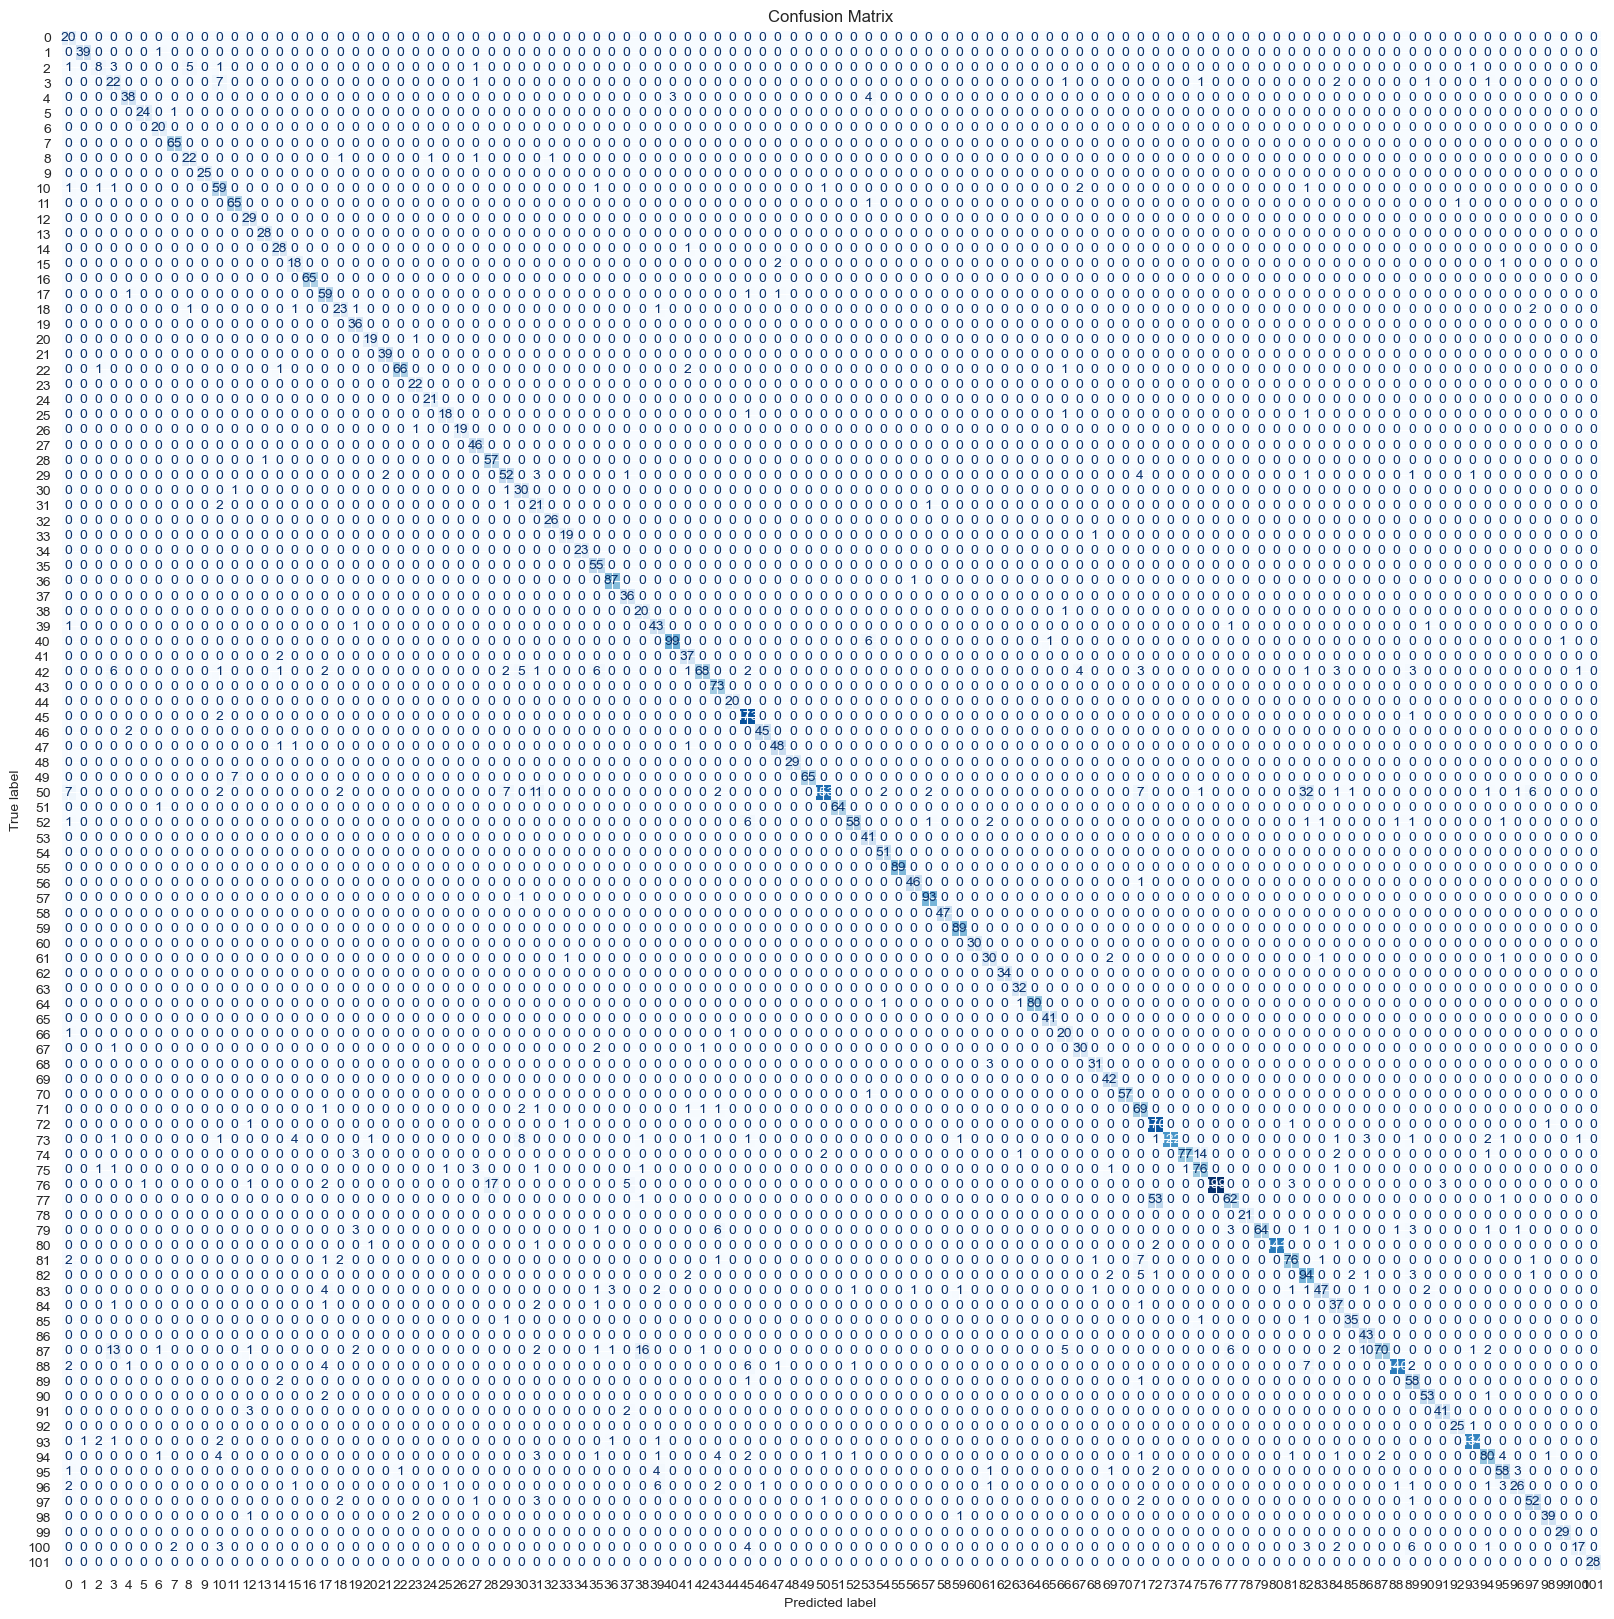

Test: loss=2.0196  acc_cls=0.8798  acc_txt=0.8541


In [22]:
best_val = -1.0
best_head = None
earlystop = EarlyStopper()
vpt_stats = []
for ep in range(1,cfg.epochs+1):
    training = run_epoch(train_loader, train=True)
    val = run_epoch(val_loader, train=False)
    print(f"VPT tuned Model on epoch [{ep}/{cfg.epochs}] "
          f"Train: loss={training['loss']:.4f} acc_cls={training['acc_cls']:.4f} acc_txt={training['acc_txt']:.4f} | "
          f"Val:   loss={val['loss']:.4f} acc_cls={val['acc_cls']:.4f} acc_txt={val['acc_txt']:.4f}")


    if val["acc_cls"] > best_val:
        best_val = val["acc_cls"]
        best_head = { k: v.detach().cpu() for k, v in head.state_dict().items() } # Detach the parameters from autograd (keeps weights only)
    earlystop.report(val['loss'])
    vpt_stats.append([ep,training['loss'],val['loss'],training['acc_cls'],val['acc_cls']])
    if earlystop.stop_flag():
        print(f"Early stop triggered...Exiting on epoch {ep}")
        break

if best_head is not None:
    head.load_state_dict({k: v.to(device) for k, v in best_head.items()})
te = test_epoch(test_loader, train=False)
print(f"Test: loss={te['loss']:.4f}  acc_cls={te['acc_cls']:.4f}  acc_txt={te['acc_txt']:.4f}")

pd.DataFrame(vpt_stats).to_csv('../vpt.csv')

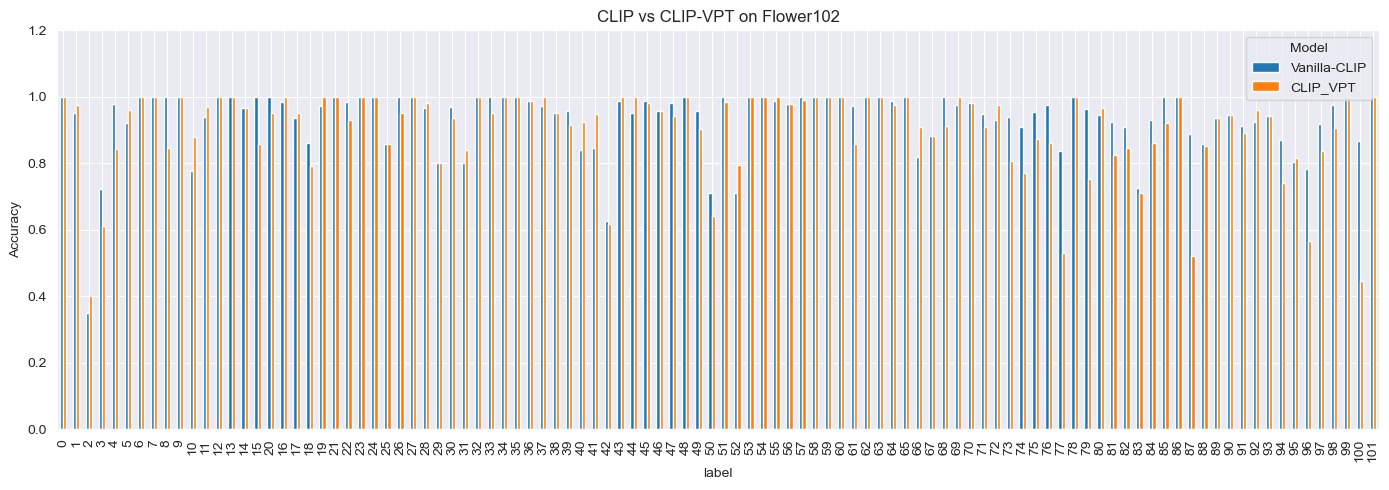

In [23]:
# Draw Label-wise
df = pd.DataFrame(list(te["label_acc"].items()), columns=["label", "CLIP_VPT"])
df.to_csv('../vpt_stats.csv')
df2 = pd.read_csv('../clip_test.csv')
df = df.merge(df2, on='label')
df = df[['label','CLIP_VPT','Vanilla-CLIP']]

df.set_index("label")[["Vanilla-CLIP", "CLIP_VPT"]].plot(kind="bar", figsize=(14,5))
plt.ylabel("Accuracy")
plt.title("CLIP vs CLIP-VPT on Flower102")
plt.ylim(0, 1.2)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# [epoch, train_loss, val_loss, train_acc, val_acc] .columns=["epoch", "train_loss", "val_loss", "train_acc", "val_acc"]
df_base = pd.read_csv('../vanilla.csv').drop(columns=['Unnamed: 0'])
df_base.columns = ["epoch", "train_loss", "val_loss", "train_acc", "val_acc"]
df_vpt = pd.read_csv('../vpt.csv').drop(columns=['Unnamed: 0'])
df_vpt.columns = ["epoch", "train_loss", "val_loss", "train_acc", "val_acc"]


plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
sns.lineplot(data=df_base, x="epoch", y="train_loss", label="Baseline Train", color="#1f77b4", linestyle="-")
sns.lineplot(data=df_base, x="epoch", y="val_loss",   label="Baseline Val",   color="#1f77b4", linestyle="--")
sns.lineplot(data=df_vpt,  x="epoch", y="train_loss", label="VPT Train",      color="#d62728", linestyle="-")
sns.lineplot(data=df_vpt,  x="epoch", y="val_loss",   label="VPT Val",        color="#d62728", linestyle="--")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.legend()


plt.subplot(1,2,2)
sns.lineplot(data=df_base, x="epoch", y="train_acc", label="Baseline Train", color="#1f77b4", linestyle="-")
sns.lineplot(data=df_base, x="epoch", y="val_acc",   label="Baseline Val",   color="#1f77b4", linestyle="--")
sns.lineplot(data=df_vpt,  x="epoch", y="train_acc", label="VPT Train",      color="#d62728", linestyle="-")
sns.lineplot(data=df_vpt,  x="epoch", y="val_acc",   label="VPT Val",        color="#d62728", linestyle="--")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


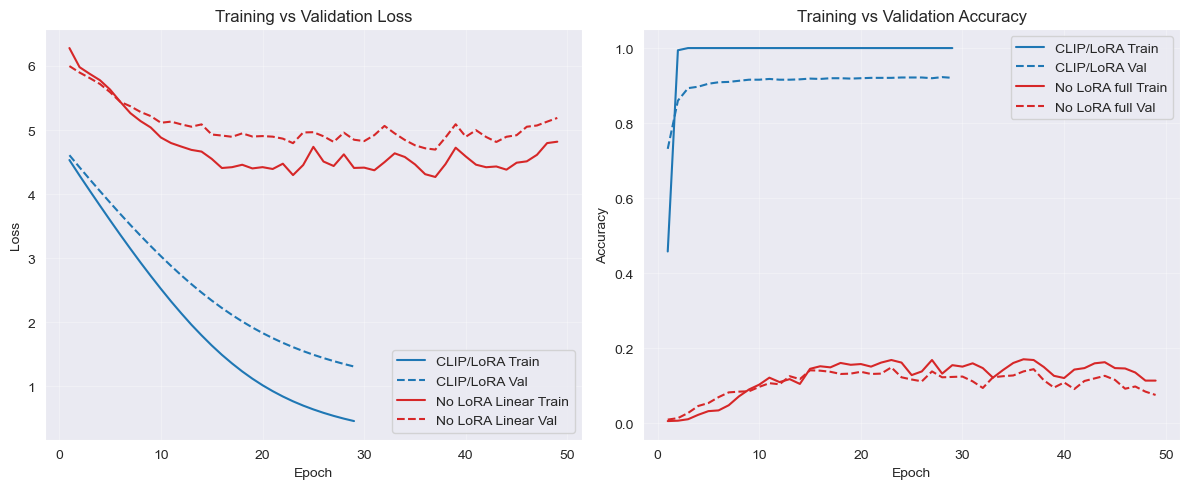

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# [epoch, train_loss, val_loss, train_acc, val_acc] .columns=["epoch", "train_loss", "val_loss", "train_acc", "val_acc"]
df_nolora = pd.read_csv('nolora-vanilla.csv').drop(columns=['Unnamed: 0'])
df_base = pd.read_csv('../vanilla.csv').drop(columns=['Unnamed: 0'])
df_base.columns = ["epoch", "train_loss", "val_loss", "train_acc", "val_acc"]
df_nolora.columns = ["epoch", "train_loss", "val_loss", "train_acc", "val_acc"]

plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
sns.lineplot(data=df_base, x="epoch", y="train_loss", label="CLIP/LoRA Train", color="#1f77b4", linestyle="-")
sns.lineplot(data=df_base, x="epoch", y="val_loss",   label="CLIP/LoRA Val",   color="#1f77b4", linestyle="--")
sns.lineplot(data=df_nolora,  x="epoch", y="train_loss", label="No LoRA Linear Train",      color="#d62728", linestyle="-")
sns.lineplot(data=df_nolora,  x="epoch", y="val_loss",   label="No LoRA Linear Val",        color="#d62728", linestyle="--")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.legend()


plt.subplot(1,2,2)
sns.lineplot(data=df_base, x="epoch", y="train_acc", label="CLIP/LoRA Train", color="#1f77b4", linestyle="-")
sns.lineplot(data=df_base, x="epoch", y="val_acc",   label="CLIP/LoRA Val",   color="#1f77b4", linestyle="--")
sns.lineplot(data=df_nolora,  x="epoch", y="train_acc", label="No LoRA full Train",      color="#d62728", linestyle="-")
sns.lineplot(data=df_nolora,  x="epoch", y="val_acc",   label="No LoRA full Val",        color="#d62728", linestyle="--")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()
